In [213]:
import numpy as np
import modules_solar as mds
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# Read the data from Ricardo in order to get initial conditions in order to evolv the system  

In [148]:
data = np.loadtxt('orbit_evolution.log', skiprows = 1).T

out = {}
out['fail'] = False

#Make the table reading automatic
out['t'     ] = data[0, :]
out['xstar' ] = np.array([ data[ 1, :], data[ 2, :], data[ 3, :] ]).T
out['vstar' ] = np.array([ data[ 4, :], data[ 5, :], data[ 6, :] ]).T
out['xBH'   ] = np.array([ data[ 7, :], data[ 8, :], data[ 9, :] ]).T
out['vBH'   ] = np.array([ data[10, :], data[11, :], data[12, :] ]).T
out['xFrame'] = np.array([ data[13, :], data[14, :], data[15, :] ]).T
out['vFrame'] = np.array([ data[16, :], data[17, :], data[18, :] ]).T
out['aFrame'] = np.array([ data[19, :], data[20, :], data[21, :] ]).T

#Switch from local frame to global frame
out['xstarglobal'] = out['xstar'] + out['xFrame']
out['vstarglobal'] = out['vstar'] + out['vFrame']

#Compute acceleration of the center of mass
accx = np.gradient(out['vstar'][:, 0], out['t'], edge_order = 2)
accy = np.gradient(out['vstar'][:, 1], out['t'], edge_order = 2)
accz = np.gradient(out['vstar'][:, 2], out['t'], edge_order = 2)

out['astar'] = np.array([ accx, accy, accz ]).T
out['astarglobal'] = out['astar'] + out['aFrame']

No handles with labels found to put in legend.


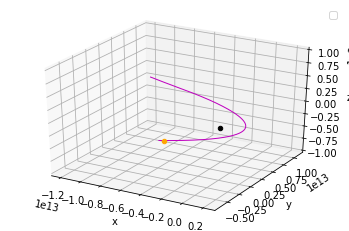

In [203]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(out['xBH'].T[0], out['xBH'].T[1], out['xBH'].T[2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(out['xstarglobal'].T[0], out['xstarglobal'].T[1], out['xstarglobal'].T[2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(out['xBH'].T[0][-1], out['xBH'].T[1][-1], out['xBH'].T[2][-1], 'o', c='black') #s=100
ax.scatter3D(out['xstarglobal'].T[0][1000], out['xstarglobal'].T[1][1000], out['xstarglobal'].T[2][1000], '0', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1000000,1000000)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


#plt.savefig('ne-circular2rt-5orbits.eps',bbox_inches='tight')#, dpi=300

plt.show()

# Convert Units to my Units

Will run in solar mass, and solar radius units

In [150]:
#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_sun_SI)  #from vel km/sec to code units (U)
acckmsec_U = 1000./np.sqrt((G_new_SI**2)*(M_sun_SI**2)/(R_sun_SI**4))  #from acc km/sec^2 to code Units
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_sun_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

In [115]:
#Define the bh
bh = mds.Particle("BH", 1000, 0,0) #stellar type, mass, radius, spin

#Define the star
star = mds.Particle("WD",1,1,0)

In [116]:
bhstarparab = mds.Binary(bh,star, 100*star.radi,0) #Particle1, Particle2, distance, ecc. 
bhstarparab.r

array([[  0.0999001,   0.       ,   0.       ],
       [-99.9000999,   0.       ,   0.       ]])

Ricardo's units are CGS centimetre-gram-second
 
M_sun = 1.989e33 grams = 1 solar mass
M_bh = 1000 solar mass
Rstar = 6.957e10 cm = 1 Solar Radius
Polytropic index = 1.5

Go from cm to km -  100,000 cm - 1 km

Go from km to solar radius 696340 km - 1 Solar radius 

velocity is in cm/s: 

Go from cm/s to km/s: v/100000


Initial distance = 6.957e12 cm

Remember that n_E = (2/3)k(l^5)/(G)

k = 0.143279 for n = 1.5

First obtain the position, velocity and acceleration in code units at each timestep

In [211]:
print(star.ntide)

0.09551933333333332


In [151]:
xstarkm =  out['xstarglobal'] / 100000
xbhkm = out['xBH'] / 100000
vstarkms = out['vstarglobal'] / 100000
vbhkms = out['vBH'] / 100000
xstarsr = xstarkm /  696340
xbhsr = xbhkm / 696340

In [243]:
outcu = {}
outcu['fail'] = False

#Make the table reading automatic
outcu['t'     ] = data[0, :]/time_U
outcu['xstar' ] = np.array([ data[ 1, :], data[ 2, :], data[ 3, :] ]).T/(100000*696340)
outcu['vstar' ] = np.array([ data[ 4, :], data[ 5, :], data[ 6, :] ]).T*kmsec_U/100000
outcu['xBH'   ] = np.array([ data[ 7, :],
                            data[ 8, :], data[ 9, :] ]).T/(100000*696340)
outcu['vBH'   ] = np.array([ data[10, :], data[11, :], data[12, :] ]).T*kmsec_U/100000
outcu['xFrame'] = np.array([ data[13, :], data[14, :], data[15, :] ]).T/(100000*696340)
outcu['vFrame'] = np.array([ data[16, :], data[17, :], data[18, :] ]).T*kmsec_U/ 100000
outcu['aFrame'] = np.array([ data[19, :], data[20, :], data[21, :] ]).T*acckmsec_U/100000 #Need to convert this to correct units

#Switch from local frame to global frame
outcu['xstarglobal'] = outcu['xstar'] + outcu['xFrame']
outcu['vstarglobal'] = outcu['vstar'] + outcu['vFrame']

#Compute acceleration of the center of mass
accxcu = np.gradient(outcu['vstar'][:, 0], outcu['t'], edge_order = 2)
accycu = np.gradient(outcu['vstar'][:, 1], outcu['t'], edge_order = 2)
acczcu = np.gradient(outcu['vstar'][:, 2], outcu['t'], edge_order = 2)

outcu['astar'] = np.array([ accxcu, accycu, acczcu ]).T*acckmsec_U/100000
outcu['astarglobal'] = outcu['astar'] + outcu['aFrame']

# Compare positions

In [244]:
print(outcu['xstarglobal'])

[[-3.99233130e+01 -9.14758020e+01 -1.00251257e-14]
 [-3.99155618e+01 -9.14707274e+01 -1.01070523e-11]
 [-3.99078104e+01 -9.14656526e+01 -2.00332688e-11]
 ...
 [-1.71219055e+02  1.55205211e+02  1.32169722e-07]
 [-1.71223288e+02  1.55206844e+02  1.32213902e-07]
 [-1.71227517e+02  1.55208475e+02  1.32258171e-07]]


In [245]:
print(r[1].T)

[[-3.99233130e+01 -9.14758020e+01 -1.00251257e-14]
 [-3.99155557e+01 -9.14707235e+01 -1.00251256e-14]
 [-3.99077984e+01 -9.14656447e+01 -1.00251256e-14]
 ...
 [-1.71492507e+02  1.55138314e+02  4.09773064e-14]
 [-1.71496736e+02  1.55139941e+02  4.09779802e-14]
 [-1.71500972e+02  1.55141570e+02  4.09786550e-14]]


## Ratio of positions from both simulations

In [246]:
print(outcu['xstarglobal'][:][:-1]/r[1].T)

[[1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [1.00000015e+00 1.00000004e+00 1.00817213e+03]
 [1.00000030e+00 1.00000009e+00 1.99830603e+03]
 ...
 [9.98380807e-01 1.00042069e+00 3.22436112e+06]
 [9.98380833e-01 1.00042071e+00 3.22538400e+06]
 [9.98380860e-01 1.00042073e+00 3.22640902e+06]]


# Compare velocities 

In [247]:
print(outcu['vstarglobal'])

[[ 3.74078280e+00  2.44891719e+00  0.00000000e+00]
 [ 3.74086581e+00  2.44910739e+00 -2.20910297e-14]
 [ 3.74094881e+00  2.44929763e+00 -2.27716122e-14]
 ...
 [-2.74144334e+00  1.05750110e+00  3.00116080e-11]
 [-2.74142196e+00  1.05748173e+00  2.99906697e-11]
 [-2.74140061e+00  1.05746238e+00  2.99698694e-11]]


In [248]:
print(v[1].T)

[[ 3.74078280e+00  2.44891719e+00  0.00000000e+00]
 [ 3.74086590e+00  2.44910762e+00  2.08488227e-20]
 [ 3.74094901e+00  2.44929807e+00  4.17022976e-20]
 ...
 [-2.74084138e+00  1.05419927e+00  4.36610277e-16]
 [-2.74082002e+00  1.05417995e+00  4.36605172e-16]
 [-2.74079863e+00  1.05416060e+00  4.36600061e-16]]


# Compare accelerations

In [250]:
print(outcu['astarglobal'])

[[ 4.00270367e-02  9.17134628e-02 -5.77151876e-16]
 [ 4.00285907e-02  9.17297451e-02 -2.00367403e-16]
 [ 4.00301439e-02  9.17460316e-02 -1.05807061e-17]
 ...
 [ 1.38287735e-02 -1.25369203e-02 -4.94152909e-16]
 [ 1.38283554e-02 -1.25363632e-02 -4.93037386e-16]
 [ 1.38279378e-02 -1.25358068e-02 -4.90300101e-16]]


In [251]:
print(aT[1].T)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.00751892e-02  9.18365405e-02  1.00551637e-17]
 [ 4.00767454e-02  9.18528585e-02  1.00575088e-17]
 ...
 [ 1.38394693e-02 -1.25196845e-02 -3.30768272e-18]
 [ 1.38390516e-02 -1.25191292e-02 -3.30755568e-18]
 [ 1.38386333e-02 -1.25185730e-02 -3.30742845e-18]]


In [236]:
# need to match outcu['astar'] and out['astar']

In [239]:
print('CGS units')
print(out['astar'])
print('Natural units')
print(outcu['astar'])

CGS units
[[-6.76671757e-09 -6.73691583e-08 -4.33384773e-07]
 [-2.15849706e-09 -1.24023970e-08 -1.50456379e-07]
 [-1.75039033e-10  1.93829072e-08 -7.94507838e-09]
 ...
 [ 3.20294672e-02  1.26765425e-02 -3.71060643e-07]
 [ 3.20867288e-02  1.26984352e-02 -3.70222994e-07]
 [ 3.21438309e-02  1.27202876e-02 -3.68167560e-07]]
Natural units
[[-2.46937065e-13 -2.45849513e-12 -1.58154619e-11]
 [-7.87697910e-14 -4.52599281e-13 -5.49058777e-12]
 [-6.38767979e-15  7.07338258e-13 -2.89938854e-13]
 ...
 [ 1.16884775e-06  4.62603644e-07 -1.35410744e-11]
 [ 1.17093739e-06  4.63402571e-07 -1.35105062e-11]
 [ 1.17302122e-06  4.64200028e-07 -1.34354974e-11]]


In [242]:
out['astar']*acckmsec_U/100000 #This is how it transform

array([[-2.46937065e-13, -2.45849513e-12, -1.58154619e-11],
       [-7.87697910e-14, -4.52599281e-13, -5.49058777e-12],
       [-6.38767979e-15,  7.07338258e-13, -2.89938854e-13],
       ...,
       [ 1.16884775e-06,  4.62603644e-07, -1.35410744e-11],
       [ 1.17093739e-06,  4.63402571e-07, -1.35105062e-11],
       [ 1.17302122e-06,  4.64200028e-07, -1.34354974e-11]])

# Now that I have the correct acceleration, I will get the Newtonian acceleration for each position, velocity and timestep of his output 

In [284]:
print(np.shape(r))
np.shape(out['xstarglobal'])

(2, 3, 58049)


(58050, 3)

### Give same shape to position vectors from hydro sim 

In [277]:
rhydro = np.array([outcu['xBH'].T , outcu['xstarglobal'].T])
print(np.shape(rhydro))
vhydro = np.array([outcu['vBH'].T ,outcu['vstarglobal'].T])
print(np.shape(vhydro))


(2, 3, 58050)
(2, 3, 58050)


In [278]:
print(rhydro)

[[[ 3.99233130e-02  3.99155618e-02  3.99078104e-02 ...  1.71210195e-01
    1.71214428e-01  1.71218657e-01]
  [ 9.14758020e-02  9.14707274e-02  9.14656526e-02 ... -1.55216121e-01
   -1.55217754e-01 -1.55219386e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-3.99233130e+01 -3.99155618e+01 -3.99078104e+01 ... -1.71219055e+02
   -1.71223288e+02 -1.71227517e+02]
  [-9.14758020e+01 -9.14707274e+01 -9.14656526e+01 ...  1.55205211e+02
    1.55206844e+02  1.55208475e+02]
  [-1.00251257e-14 -1.01070523e-11 -2.00332688e-11 ...  1.32169722e-07
    1.32213902e-07  1.32258171e-07]]]


In [279]:
print(r)

[[[ 3.99233130e-02  3.99155557e-02  3.99077984e-02 ...  1.71480959e-01
    1.71485189e-01  1.71489424e-01]
  [ 9.14758020e-02  9.14707235e-02  9.14656447e-02 ... -1.55138017e-01
   -1.55139644e-01 -1.55141273e-01]
  [ 0.00000000e+00 -2.16161149e-26 -8.64703109e-26 ... -5.10012277e-17
   -5.10019015e-17 -5.10025762e-17]]

 [[-3.99233130e+01 -3.99155557e+01 -3.99077984e+01 ... -1.71492507e+02
   -1.71496736e+02 -1.71500972e+02]
  [-9.14758020e+01 -9.14707235e+01 -9.14656447e+01 ...  1.55138314e+02
    1.55139941e+02  1.55141570e+02]
  [-1.00251257e-14 -1.00251256e-14 -1.00251256e-14 ...  4.09773064e-14
    4.09779802e-14  4.09786550e-14]]]


## Run the Newtonian simulation for each time step to obtain the Newtonian acceleration 

In [280]:
def HermiteUpdateN(dt, r, v, m): 
    a = acc(r, m)          # current acceleration
    adot = Jerk(r,v,m)     # current jerks
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot
    ap = acc(rp,m)          # predicted acceleration
    adotp = Jerk(rp,vp,m)  # predicted jerks 
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 *(ap-a) 
    ac = a + dt/2*(adot + adotp)
    
    return ac 

In [281]:
N=2
massv = np.ones(N)#/N #Remove the N if not necessary
massv[0]=bh.mass
massv[1]=star.mass

aNhydro = np.zeros((2,3,(len(outcu['t'])-1)))


for i in range(1,len(outcu['t'])):
    (aNhydro[:,:,i-1]) = HermiteUpdateN(dtcu[i-1], rhydro[:,:,i-1], vhydro[:,:,i-1], massv)

In [282]:
print(aNhydro)

[[[-4.00751857e-05 -4.00767408e-05 -4.00782951e-05 ... -1.38457228e-05
   -1.38453043e-05 -1.38448862e-05]
  [-9.18365325e-05 -9.18528380e-05 -9.18691475e-05 ...  1.25507560e-05
    1.25501983e-05  1.25496412e-05]
  [-1.00551629e-20 -1.01397434e-17 -2.01027065e-17 ...  1.06737422e-14
    1.06767171e-14  1.06796997e-14]]

 [[ 4.00751857e-02  4.00767408e-02  4.00782951e-02 ...  1.38457228e-02
    1.38453043e-02  1.38448862e-02]
  [ 9.18365325e-02  9.18528380e-02  9.18691475e-02 ... -1.25507560e-02
   -1.25501983e-02 -1.25496412e-02]
  [ 1.00551629e-17  1.01397434e-14  2.01027065e-14 ... -1.06737422e-11
   -1.06767171e-11 -1.06796997e-11]]]


In [283]:
print(aN)

[[[ 0.00000000e+00 -4.00751857e-05 -4.00767420e-05 ... -1.38394693e-05
   -1.38390516e-05 -1.38386332e-05]
  [ 0.00000000e+00 -9.18365325e-05 -9.18528506e-05 ...  1.25196845e-05
    1.25191291e-05  1.25185730e-05]
  [ 0.00000000e+00 -1.00551629e-20 -1.00575079e-20 ...  3.30768272e-21
    3.30755567e-21  3.30742844e-21]]

 [[ 0.00000000e+00  4.00751857e-02  4.00767420e-02 ...  1.38394693e-02
    1.38390516e-02  1.38386332e-02]
  [ 0.00000000e+00  9.18365325e-02  9.18528506e-02 ... -1.25196845e-02
   -1.25191291e-02 -1.25185730e-02]
  [ 0.00000000e+00  1.00551629e-17  1.00575079e-17 ... -3.30768272e-18
   -3.30755567e-18 -3.30742844e-18]]]


In [217]:
#print(outcu['astarglobal'])
#print(out['astarglobal'])
print(outcu['astar'])
print(out['astar'])

[[-2.46937065e-13 -2.45849513e-12 -1.58154619e-11]
 [-7.87697910e-14 -4.52599281e-13 -5.49058777e-12]
 [-6.38767979e-15  7.07338258e-13 -2.89938854e-13]
 ...
 [ 1.16884775e-06  4.62603644e-07 -1.35410744e-11]
 [ 1.17093739e-06  4.63402571e-07 -1.35105062e-11]
 [ 1.17302122e-06  4.64200028e-07 -1.34354974e-11]]
[[-6.76671757e-09 -6.73691583e-08 -4.33384773e-07]
 [-2.15849706e-09 -1.24023970e-08 -1.50456379e-07]
 [-1.75039033e-10  1.93829072e-08 -7.94507838e-09]
 ...
 [ 3.20294672e-02  1.26765425e-02 -3.71060643e-07]
 [ 3.20867288e-02  1.26984352e-02 -3.70222994e-07]
 [ 3.21438309e-02  1.27202876e-02 -3.68167560e-07]]


In [188]:
outcu['xBH'][0]

array([0.03992331, 0.0914758 , 0.        ])

In [201]:
aT[1][0][9000:9100]

array([0.02538537, 0.0253764 , 0.02536738, 0.02535834, 0.02534926,
       0.02534017, 0.02533107, 0.02532197, 0.02531286, 0.02530374,
       0.0252946 , 0.02528545, 0.02527628, 0.0252671 , 0.02525789,
       0.02524867, 0.02523941, 0.02523013, 0.02522081, 0.02521146,
       0.02520209, 0.0251927 , 0.0251833 , 0.02517389, 0.02516445,
       0.025155  , 0.02514552, 0.02513603, 0.02512651, 0.02511697,
       0.02510742, 0.02509785, 0.02508825, 0.02507864, 0.02506901,
       0.02505937, 0.02504971, 0.02504004, 0.02503036, 0.02502066,
       0.02501096, 0.02500124, 0.0249915 , 0.02498175, 0.02497199,
       0.02496221, 0.02495241, 0.0249426 , 0.02493277, 0.02492291,
       0.02491304, 0.02490314, 0.02489322, 0.02488328, 0.02487332,
       0.02486333, 0.02485331, 0.02484327, 0.0248332 , 0.0248231 ,
       0.02481298, 0.02480283, 0.02479265, 0.02478243, 0.02477219,
       0.02476193, 0.02475163, 0.02474131, 0.02473096, 0.02472058,
       0.02471018, 0.02469975, 0.02468928, 0.0246788 , 0.02466

In [206]:
accxcu[1000:1100]*100000

array([0.00055993, 0.00056016, 0.00056039, 0.00056062, 0.00056086,
       0.00056109, 0.00056133, 0.00056156, 0.0005618 , 0.00056203,
       0.00056227, 0.0005625 , 0.00056274, 0.00056298, 0.00056322,
       0.00056346, 0.0005637 , 0.00056394, 0.00056418, 0.00056442,
       0.00056466, 0.0005649 , 0.00056514, 0.00056538, 0.00056562,
       0.00056586, 0.00056611, 0.00056635, 0.00056659, 0.00056683,
       0.00056707, 0.00056732, 0.00056756, 0.0005678 , 0.00056805,
       0.00056829, 0.00056854, 0.00056878, 0.00056902, 0.00056926,
       0.00056951, 0.00056975, 0.00056999, 0.00057024, 0.00057048,
       0.00057073, 0.00057097, 0.00057122, 0.00057146, 0.0005717 ,
       0.00057195, 0.00057219, 0.00057244, 0.00057269, 0.00057293,
       0.00057317, 0.00057342, 0.00057367, 0.00057391, 0.00057416,
       0.0005744 , 0.00057465, 0.0005749 , 0.00057514, 0.00057539,
       0.00057564, 0.00057589, 0.00057614, 0.00057638, 0.00057663,
       0.00057688, 0.00057713, 0.00057738, 0.00057763, 0.00057

In [96]:

#vbhcu = vbhkms*kmsec_U
#vstarcu = vstarkms*kmsec_U

#Compute acceleration of the center of mass
#accx = np.gradient(out['vstar'][:, 0]*kmsec_U, out['t'], edge_order = 2) #In code units
#accy = np.gradient(out['vstar'][:, 1]*kmsec_U, out['t'], edge_order = 2)
#accz = np.gradient(out['vstar'][:, 2]*kmsec_U, out['t'], edge_order = 2)

#out['astar'] = np.array([ accx, accy, accz ]).T
#out['astarglobal'] = out['astar'] + out['aFrame']


No handles with labels found to put in legend.


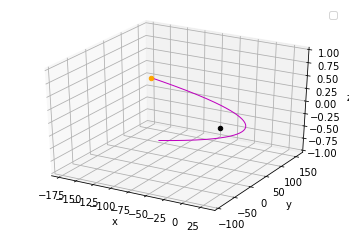

In [14]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(xbhsr.T[0], xbhsr.T[1], xbhsr.T[2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(xstarsr.T[0], xstarsr.T[1], xstarsr.T[2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(xbhsr.T[0][-1], xbhsr.T[1][-1], xbhsr.T[2][-1], 'o', c='black') #s=100
ax.scatter3D(xstarsr.T[0][-1], xstarsr.T[1][-1], xstarsr.T[2][-1], '0', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


#plt.savefig('ne-circular2rt-5orbits.eps',bbox_inches='tight')#, dpi=300

plt.show()

In [ ]:
relposcm = out['xstarglobal'] - out['xBH'] 
relposkm = ( out['xstarglobal'] - out['xBH'] ) / 100000
relpossr = relposkm / 696340
relvelkms = (out['vstarglobal'] - out['vBH'] ) / 100000

# For each position of the star that Ricardo gave me, compute the Newtonian corrected acceleration

(2, 3, 58049)


In [ ]:
print(np.shape())

#  EFT

# Newtonian and Tides 

In [298]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;

def acctide(r,m,ne): #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                a[i] += -(9.)*ne[i]*((m[j]**2)/m[i])*(runi)/(rn**7.0) #Acceleration at each time step 
    return a # return acceleration

def Jerktide(r,v,m, ne): #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                Je[i] += - (9.0)*ne[i]*((m[j]**2)/m[i])*( vrel/rn**8.0 - 8.*((vrel*rrel).sum())*(rrel)/(rn**10.0) ) 
    return Je;


def HermiteUpdatetidedt(dt, r, v, m, ns): # m mass of the star
    
    aN = acc(r, m) 
    aT = acctide(r, m, ns)
    a = aN + aT           # current acceleration
    aNdot = Jerk(r,v,m)
    aTdot = Jerktide(r, v, m, ns)
    adot = aNdot + aTdot # current jerks
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aTp = acctide(rp, m, ns)
    ap = aNp + aTp         # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aTdotp = Jerktide(rp, vp, m, ns)
    adotp = aNdotp + aTdotp  # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp + adot)
    aNc = aN + dt/2*(aNdotp + aNdot)
 
    return rc,vc,ac,aNc,dtp

def Hermite4thtidedt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    ntidev = np.array([pri.ntide, sec.ntide])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt[0]
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],aN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt[i-1], r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
        time[i] = time[i-1] + Dt[i-1]#
        #if time[i] >= timelimit:
        #    break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    a_res = a_res[:,:,:i]
    #adot_res = adot_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    #adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, a_res, aN_res, dtp, time






In [302]:
#Define initial position as in Ricardo's simulation #Start at initial position sbhsr[1000]
bhstarparab.r[0] = xbhsr[0] 
bhstarparab.r[1] = xstarsr[0]
#Define initial velocity 
bhstarparab.v[0] = vbhkms[0]*kmsec_U
bhstarparab.v[1] = vstarkms[0]*kmsec_U

In [303]:
print(bhstarparab.r[0])
print(bhstarparab.r[1])

[0.03992331 0.0914758  0.        ]
[-3.99233130e+01 -9.14758020e+01 -1.00251257e-14]


In [317]:
print(bhstarparab.v[0])
print(bhstarparab.v[1])

[-0.00374078 -0.00244892  0.        ]
[3.7407828  2.44891719 0.        ]


In [304]:
timecu = out['t']/time_U

In [305]:
timecu[-1] - timecu[-2]

0.0015438547306700912

In [306]:
timecu[2] - timecu[1]

0.002073665251181171

Make a timestep array

In [307]:
dtcu = np.zeros(len(timecu)-1)

for i in range(1,len(timecu)):
    dtcu[i-1] = timecu[i] - timecu[i-1]


In [308]:
Nsteps = len(timecu)

In [309]:
print(bhstarparab)

In [310]:
r,v,aT,aN,dtp,time = Hermite4thtidedt(bh,star, bhstarparab, Nsteps, dtcu)

In [311]:
print(time[-1])
print(timecu[-2])
print(dtp)

81.58068754074631
81.58068754074631
[0.00207369 0.00207369 0.00207367 ... 0.00154313 0.00154318 0.00154549]


No handles with labels found to put in legend.


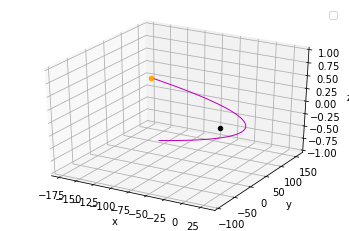

In [312]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(r[0][0], r[0][1], r[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(r[1][0], r[1][1], r[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(r[0][0][-1], r[0][1][-1], r[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(r[1][0][-1], r[1][1][-1], r[1][2][-1], '0', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


#plt.savefig('ne-circular2rt-5orbits.eps',bbox_inches='tight')#, dpi=300

plt.show()

In [313]:
print(np.shape(aT[1].T))

(58049, 3)


In [314]:
#aTcoc = aTco + adotTco*dtpwtco#Acceleration corrected
#aNcoc = aNco + adotNco*dtpwtco

aratio = np.zeros_like(aN[1].T)
for i in range(len(aN[1].T)-1):
    aratio[i+1][0] = (aT[1].T[i+1][0])/(aN[1].T[i+1][0])
    aratio[i+1][1] = (aT[1].T[i+1][1])/(aN[1].T[i+1][1])
    #print(aratio[i][1])
    
#define relative position
relpos = r[1].T - r[0].T 
#define relative velocity
relvel = v[1].T - v[0].T

normrelpos = np.zeros([len(relpos), 1]) 
normrelvel = np.zeros([len(relvel), 1]) 

for i in range(len(normrelpos)):
    normrelpos[i] = np.sqrt(relpos[i][0]**2 + relpos[i][1]**2 + relpos[i][2]**2)
    normrelvel[i] = np.sqrt(relvel[i][0]**2 + relvel[i][1]**2 + relvel[i][2]**2)
    
print(len(normrelpos.T[0]))
print(min(normrelpos))
print(max(normrelpos))

58049
[29.96411839]
[231.4919065]


In [315]:
n_ex = (normrelpos.T[0]**5)*(1./9)*(1.*star.mass/bh.mass)*(aratio.T[0] - 1) 
n_ey = (normrelpos.T[0]**5)*(1./9)*(1.*star.mass/bh.mass)*(aratio.T[1] - 1)

No handles with labels found to put in legend.


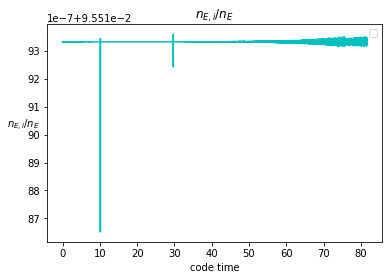

In [316]:
plt.plot(time[1:], n_ex[1:], 'c-', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,30)
#plt.ylim(0.0955,0.09555)
plt.xlabel('code time')
plt.ylabel(r'$n_{E,i}/n_E$',rotation=0)

plt.title(r'$n_{E,i} / n_E$ ')
plt.legend()
#plt.savefig('ne-evolution-circular-0.001-4rs-5orbits.eps', bbox_inches='tight')#, dpi=300

plt.show()

In [72]:
star.ntide

0.09551933333333332

In [75]:
len(r[0].T)

58049

In [294]:
print(aratio)

[[0.         0.         0.        ]
 [1.00000009 1.00000009 0.        ]
 [1.00000009 1.00000009 0.        ]
 ...
 [1.         1.         0.        ]
 [1.         1.         0.        ]
 [1.         1.         0.        ]]


In [292]:
print(np.shape(aratio))

(58049, 3)
